In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=e76704bc7f2e2e64debdcbfe2b66d0475523bb484af685633d4222b3a770eed0
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
import os
import cv2
import shutil
# import imutils
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# IGNORING UNNECESSARRY WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

2024-08-04 09:49:08.189395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 09:49:08.189534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 09:49:08.315845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset & Declare Variables

In [3]:
base_dir = '/kaggle/input/classification-dataset/healthy_and_tumor'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

LABELS = ['healthy', 'tumor']
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

In [4]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds()

# Helper Functions for Analysing Data

In [5]:
def load_images_and_labels(base_dir, labels, color_mode='rgb'):
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    for label in labels:
        # Load training images
        train_dir = os.path.join(base_dir, 'train', label)
        for img_name in os.listdir(train_dir):
            img_path = os.path.join(train_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_train.append(img)
                y_train.append(labels.index(label))

        # Load validation images
        val_dir = os.path.join(base_dir, 'validation', label)
        for img_name in os.listdir(val_dir):
            img_path = os.path.join(val_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_val.append(img)
                y_val.append(labels.index(label))

        # Load test images
        test_dir = os.path.join(base_dir, 'test', label)
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_test.append(img)
                y_test.append(labels.index(label))

    # Convert lists to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

def print_data_shape(x_train, y_train, x_val, y_val, x_test, y_test):
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
def sample_images_224(x_train):
    images = [x_train[i] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
def display_sample_images(x, y, labels, num_samples=5):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(np.arange(x.shape[0]), num_samples, replace=False)
    for i, index in enumerate(indices):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(x[index], cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (Matplotlib)
        plt.title(f"Label: {labels[y[index]]}")
        plt.axis("off")
    plt.show()
    
# Shuffle the datasets
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    return x[indices], y[indices]
    
def data_normalization(x_test):    
    return x_test / 255.0

# Helper Functions for Evaluating Model

In [6]:
def plot_training_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def evaluate_model(model, generator, steps, x_test, y_test):
    validation_loss, validation_acc = model.evaluate(generator, steps=steps)
    print(f"Validation loss: {validation_loss}")
    print(f"Validation accuracy: {validation_acc}")
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_acc}")
    
def plot_pred_imgs(number_images,x_test,y_test,model):
    # Choose some random images from the test set
    num_images = number_images
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)
    sample_images = x_test[random_indices]
    sample_labels_true = y_test[random_indices]

    # Predict labels for the sample images
    sample_predictions = model.predict(sample_images)
    sample_labels_pred = (sample_predictions > 0.5).astype(int).flatten()

    # Define class labels (assuming binary classification)
    class_labels = ['healthy', 'tumor']

    # Plot the sample images with true and predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"True: {class_labels[sample_labels_true[i]]}\nPred: {class_labels[sample_labels_pred[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_cm(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred_classes)
    
    # Define class labels
    class_labels = ['healthy', 'tumor'] # healthy=0, tumor=1

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_class_report(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Define class labels
    class_labels = ['healthy', 'tumor']

    # Generate classification report
    report = classification_report(y_test, test_pred_classes, target_names=class_labels)

    print("Classification Report:\n", report)

def run_model(model,train_generator,steps_per_epoch,epochs,val_generator,validation_steps, callbacks,boolean=False):
    if boolean == True:
        history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks = [callbacks]
    )
    else:    
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=validation_steps
        )
    return history

def save_model(model, name):
    model.save(f'{name}.h5')

# Data Stats

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = load_images_and_labels(base_dir, LABELS, color_mode=COLOR_MODE)

x_train, y_train = shuffle_data(x_train, y_train)
x_val, y_val = shuffle_data(x_val, y_val)
x_test, y_test = shuffle_data(x_test, y_test)

x_test = data_normalization(x_test)
print_data_shape(x_train, y_train, x_val, y_val, x_test, y_test)

x_train shape: (2100, 224, 224, 3)
y_train shape: (2100,)
x_val shape: (450, 224, 224, 3)
y_val shape: (450,)
x_test shape: (450, 224, 224, 3)
y_test shape: (450,)


# Check Data Imbalance

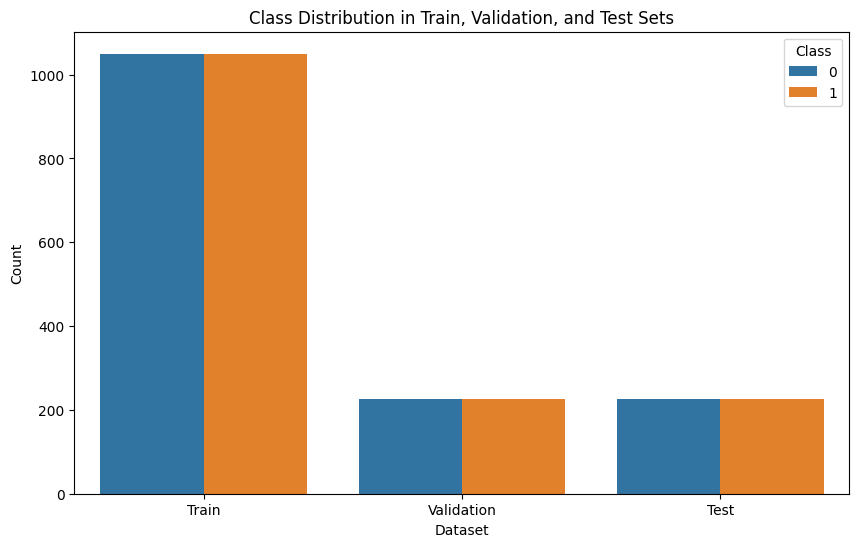

In [8]:
def plot_class_distribution(y_train, y_val, y_test):
    # Combine data for plotting
    data = {
        'Dataset': ['Train'] * len(y_train) + ['Validation'] * len(y_val) + ['Test'] * len(y_test),
        'Class': np.concatenate([y_train, y_val, y_test])
    }
    
    # Convert to DataFrame
    import pandas as pd
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Dataset', hue='Class')
    plt.title('Class Distribution in Train, Validation, and Test Sets')
    plt.xlabel('Dataset')
    plt.ylabel('Count')
    plt.legend(title='Class')
    plt.show()

# Call the function
plot_class_distribution(y_train, y_val, y_test)

# Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

# Create a generator for the validation data (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

# VGG-16 Implementation

## Convolutional Layers

In [12]:
conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=INPUT_SHAPE)

conv_base.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Fine-tuning

In [14]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [15]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Using functional api method to construct fine-tuned VGG16

In [16]:
# Add the final classification layers
x = Flatten()(conv_base.output)
x = Dense(128, activation='relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create final model
vgg_model = Model(inputs=conv_base.input, outputs=outputs)

In [17]:
vgg_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 10,290,945 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Model Compilation & Callbacks

In [18]:
vgg_model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.00002),metrics=['acc'])

In [19]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

callbacks = [es, reduce_lr]

## Running the model

In [84]:
history = run_model(vgg_model,train_generator,100,30,val_generator,50,callbacks,True)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - acc: 0.6856 - loss: 0.5694 - val_acc: 0.8911 - val_loss: 0.2814 - learning_rate: 2.0000e-05
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - acc: 0.8537 - loss: 0.3722 - val_acc: 0.9222 - val_loss: 0.1771 - learning_rate: 2.0000e-05
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - acc: 0.8612 - loss: 0.5749 - val_acc: 0.9578 - val_loss: 0.9994 - learning_rate: 2.0000e-05
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - acc: 0.8984 - loss: 0.2524 - val_acc: 0.9578 - val_loss: 0.5949 - learning_rate: 2.0000e-05
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - acc: 0.9213 - loss: 0.2411 - val_acc: 0.9800 - val_loss: 0.6887 - learning_rate: 2.0000e-05
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - acc: 0.9197 - loss: 0.1893 - val_acc: 0.9644 - val_loss: 0.0802 - learning_rate: 2.0000e-05
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - acc: 0.9347 - loss: 0.1739 - val_acc: 0.9778 - va

# Model Evaluation

## Learning Curves

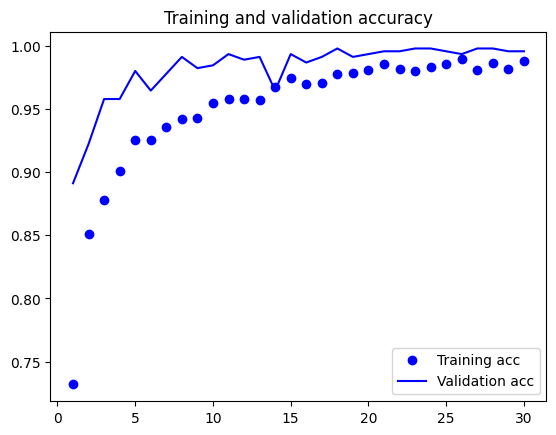

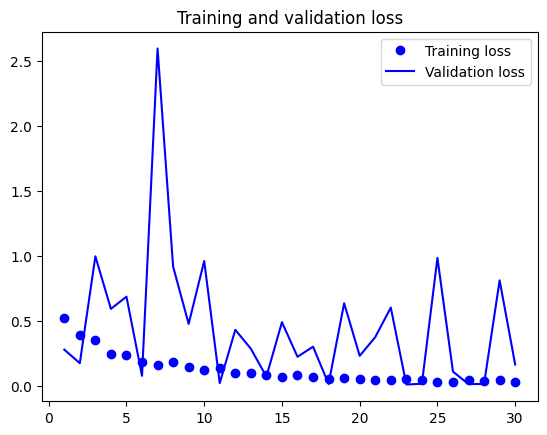

In [85]:
plot_training_curve(history)

## Evaluation on validation & test set

In [86]:
evaluate_model(vgg_model, val_generator, 50, x_test, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - acc: 0.9990 - loss: 0.0218
Validation loss: 0.13686774671077728
Validation accuracy: 0.995555579662323
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - acc: 0.9976 - loss: 0.0467
Test loss: 0.3384569585323334
Test accuracy: 0.995555579662323


## Confusion Matrix

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


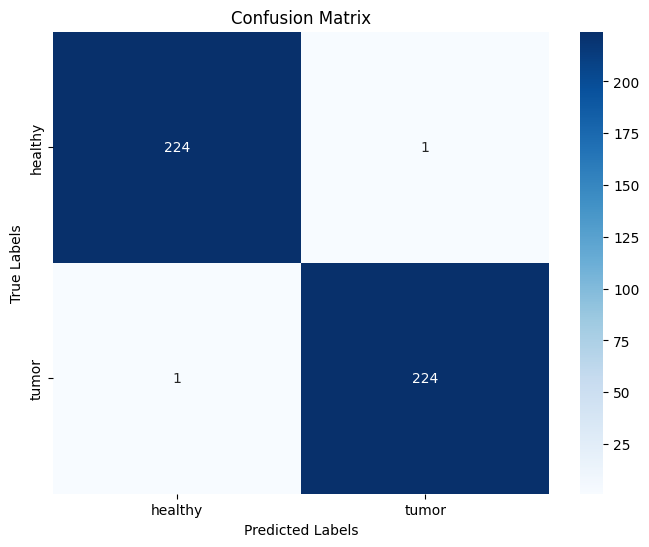

In [87]:
plot_cm(vgg_model,x_test,y_test)

## Classification report

In [88]:
plot_class_report(vgg_model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       225
       tumor       1.00      1.00      1.00       225

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



# Save model

In [42]:
save_model(vgg_model,'vgg_16')